# 区域碳收支估算期末作业



## 1. 内容
按照Farquhar模型, 写一个叶片尺度单点的光合作用模块, 可聚焦于C3热带森林（Broadleaf evergreen tree – tropical， BET，表8.2）, Vcmax 仅考虑温度和氮含量, 不考虑水分和天日照长度.

对应参数：m= 9, alpha= 0.06, CNL= 30, FLNR= 0.06, fN=0.83, SLA0= 0.012, SLAm= 0.0015, psi0= -66000, psic= -255000,

alpha 为量子效率(μmol 光子对应 μmol 二氧化碳), phi 为吸收的光合有效辐射(W/m<sup>2</sup>), 乘以系数4.6
Φ（Phi）通常用来表示光合有效辐射（PAR）的利用效率。光合有效辐射是指植物能够吸收并用于光合作用的太阳辐射范围内的辐射。Φ值是一个表示植物光合效率的参数，表示单位PAR能量被植物用于光合作用的比例。

Φ的典型取值范围是0到1，其中：

* Φ = 0 表示植物没有利用PAR进行光合作用，效率为零。
* Φ = 1 表示植物完全利用PAR进行光合作用，效率为百分之百。


叶片光合指数为wc，wj，we 的最小值，所需要的参数包括Vcmax, ci, gama, Kc/Ko, oi

gama: 光饱和点(Pa)和Kc/Ko 和oi的乘积成正比, 0.5* Kc/Ko *0.21 * oi, 0.21为氧化反应和羧化反应比值的最大值. 

Kc/Ko 关于二氧化碳和氧气的M-M常数(Pa)根据温度变化, Kc25和Ko25 分别为30.0 和30000.0, akc=2.1, ako=1.2

ci/oi分别为二氧化碳和氧气的分压，通常oi=0.209Patm (0.209*101325 Pa), ci 作为变量(暂定通过大气压计算分压), 大约为大气中的二氧化碳ppm/10

下面拆解Vcmax: 

Vcmax 为羧化作用的最大值, 在25摄氏度下的值为 (72 μmol CO<sub>2</sub> m<sup>-2</sup> s<sup>-1</sup>) 

Vcmax25= 72, Vcmax25fN= 59, Vcmax 的具体值与叶片温度 (Tv), 土壤含水量 (betat), 并且和日照长度相关: fDYL

betat: 值为0-1

当出现氮限制时, Vcmax 计算时需要乘 fN 系数, 

fTv 计算：需要 Rgas, 叶片温度 Tv, 水的熔点 Tf, 273 K.

fDYL 进行原为日照时间和最大日照时间比值的平方，简化模型后值为1.

## 2. 编写模块

In [14]:
# 定义变量(测试用)
Tv = 30 # 叶片温度，计算fTv，与 25℃的差别
bgc = False # 是否出现氮缺乏
betat = 0.8 # [0,1]
fDYL = 1 # [0.01,1]模型简化，值为1时为回归线之间，太阳直射（即日照最长的那一天）和纬度以及当天太阳高度角相关
co2 = 415 # 单位中二氧化碳体积分数（ppm）
ci = co2*0.1 # 除以十进行估计
phi = 0.8 # 取值通常为0-1
# 常量表
Rgas = 8.31e3
Tf = 273
oi = 0.209* 1.01325e5
Kc25 = 30
Ko25= 3e4
akc = 2.1
ako = 1.2
Vcmax25 = 72
fN = 0.83
alpha = 6e-2


In [15]:
# 光合作用
fTv = (1+ 2.71287**((-2.2e5+ 710*(Tv+Tf))/(1e-3)*Rgas*(Tv+Tf)))**-1 
# Tv + Tf 为实际的开尔文温度，Tv为摄氏度，Tf为修正值（273K）
Kc = Kc25*(akc)**((Tv-25)*0.1)
Ko = Ko25*(ako)**((Tv-25)*0.1)   
gama = 0.5* Kc/Ko *0.21*oi

Vcmax0 = Vcmax25*(2.4**((Tv-25)*0.1))*fTv*betat*fDYL
if bgc == False: 
    Vcmax = Vcmax0 * fN
else: 
    Vcmax = Vcmax0

wc = Vcmax*(ci-gama)/(ci+Kc*(1.0+oi/Ko))
wj = ((ci-gama)*4.6*phi*alpha)/(ci+2*gama)
we = 0.5*Vcmax

Aleaf = min (wc, wj, we)
Aleaf

0.17967852373848228

## 3.可视化

### 3.1 预处理

In [16]:
# 模块化
import numpy as np
def calculate_Aleaf(Tv=30, 
                    co2=415, 
                    fDYL=1, 
                    betat= 0.8, 
                    phi = 80, # 是百分数吗？
                    bgc = False, 
                    # 以上为变量
                    Rgas = 8.31e3,
                    Tf = 273,
                    oi = 0.209* 1.01325e5,
                    Kc25 = 30,
                    Ko25= 3e4,
                    akc = 2.1,
                    ako = 1.2,
                    Vcmax25 = 72,
                    fN = 0.83,
                    alpha = 6e-2,): 
                    # 常量
    ci = co2*0.1
    exp_part = -2.2e5 + 710*(Tv + Tf)
    exp_part /= (1e-3) * Rgas * (Tv + Tf)
    fTv = 1 / (1 + np.exp(exp_part))
    # Tv + Tf 为实际的开尔文温度，Tv为摄氏度，Tf为修正值（273K）
    Kc = Kc25*(akc)**((Tv-25)*0.1)
    Ko = Ko25*(ako)**((Tv-25)*0.1)   
    gama = 0.5* Kc/Ko *0.21*oi

    Vcmax0 = Vcmax25*(2.4**((Tv-25)*0.1))*fTv*betat*fDYL
    if bgc == False: 
        Vcmax = Vcmax0 * fN
    else: 
        Vcmax = Vcmax0

    wc = Vcmax*(ci-gama)/(ci+Kc*(1.0+oi/Ko))
    wj = ((ci-gama)*4.6*phi*alpha)/(ci+2*gama)
    we = 0.5*Vcmax

    Aleaf = min (wc, wj, we)
    # # return Aleaf, wc, wj, we
    # return wc, wj, we
    # return Aleaf
  
    #  # 决定使用了哪个分量
    # if Aleaf > 0 :
    #     # return Aleaf, 
    #     return Aleaf, wc, wj, we
    # else :
    #     return ('"ci - phi" must be bigger than 0!') # 值需大于0
    
    mode = 'null'
    if Aleaf == wc:
        mode = 'wc'
    elif Aleaf == we:
        mode = 'we'
    elif Aleaf == wj:
        mode = 'wj'
    if Aleaf < 0:
        Aleaf = 0
    # print( 
    #     wc, wj, we, 
    #       Aleaf, mode)

    return Aleaf, wc, wj, we, mode

In [17]:
calculate_Aleaf(
                co2 = 350,
                phi = 40,
#                 bgc= True,
)
print("Aleaf:", Aleaf, )


Aleaf: 0.17967852373848228


### 3.2 温度变化的影响

#### 3.2.1 每个参数

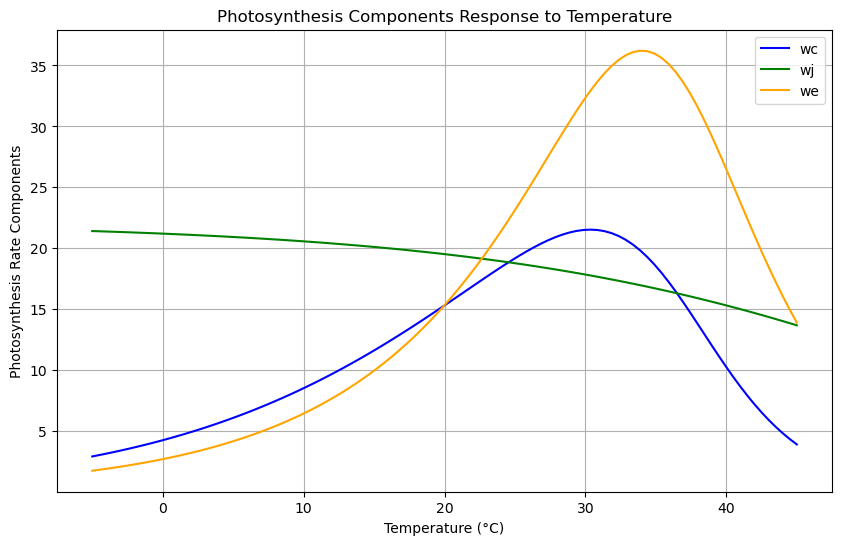

In [18]:
import matplotlib.pyplot as plt
def simulate_photosynthesis(temperature_values, co2=400, other_params=None):
    if other_params is None:
        other_params = {}

    results = {'wc': [], 'wj': [], 'we': [], 'mode': []}

    for temperature in temperature_values:
        result = calculate_Aleaf(Tv=temperature, co2=co2, **other_params)
        results['wc'].append(result[1])
        results['wj'].append(result[2])
        results['we'].append(result[3])
        results['mode'].append(result[4])

    return results

def visualize_photosynthesis_response(temperature_values, photosynthesis_data):
    plt.figure(figsize=(10, 6))

    plt.plot(temperature_values, photosynthesis_data['wc'], 
            #  marker='o', 
             linestyle='-', label='wc', color='blue'
             )
    plt.plot(temperature_values, photosynthesis_data['wj'], 
            #  marker='o', 
             linestyle='-', label='wj', color='green'
             )
    plt.plot(temperature_values, photosynthesis_data['we'], 
            #  marker='o', 
             linestyle='-', label='we', color='orange'
             )

    plt.xlabel('Temperature (°C)')
    plt.ylabel('Photosynthesis Rate Components')
    plt.title('Photosynthesis Components Response to Temperature')
    plt.grid(True)
    plt.legend()

    plt.show()

# 温度范围
co2_values = np.linspace(-5, 45, 100)

# 模拟光合作用响应，可以根据需要调整其他参数
photosynthesis_data = simulate_photosynthesis(co2_values, co2=400, other_params={'phi': 80, 'fDYL': 1, 'betat': 0.8})

# 可视化
visualize_photosynthesis_response(co2_values, photosynthesis_data)

#### 3.2.2 不同颜色绘图

In [21]:
def simulate_photosynthesis(temperature_values, co2=400, other_params=None):
    if other_params is None:
        other_params = {}

    results = {'Aleaf': [], 'mode': []}

    for temperature in temperature_values:
        result = calculate_Aleaf(Tv=temperature, co2=co2, **other_params)
        results['Aleaf'].append(result[0])
        results['mode'].append(result[4])

    return results

In [41]:
def get_mode_color(mode):
    if mode == 'wc':
        return 'red'
    elif mode == 'we':
        return 'blue'
    elif mode == 'wj':
        return 'green'
    else:
        return 'black'

In [79]:
def visualize_photosynthesis_response(temperature_values, photosynthesis_data):
    plt.figure(figsize=(10, 6))

    for i in range(len(temperature_values) - 1):
        temperature1 = temperature_values[i]
        temperature2 = temperature_values[i + 1]
        mode1 = photosynthesis_data['mode'][i]
        # mode2 = photosynthesis_data['mode'][i + 1]
        Aleaf1 = photosynthesis_data['Aleaf'][i]
        Aleaf2 = photosynthesis_data['Aleaf'][i + 1]

        plt.plot([temperature1, temperature2], [Aleaf1, Aleaf2], 
                 marker='o', 
                 markersize = 0,
                 linewidth = 2,
                 color=get_mode_color(mode1))

    plt.xlabel('Temperature (°C)')
    plt.ylabel('Photosynthesis Rate ($\mu$ mol CO$_2 m^2 s^{-1}$)')
    plt.title('Photosynthesis Response to Temperature')
    plt.grid(True)

    # Manually create legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', label='$w_e$'),
        plt.Line2D([0], [0], color='red', label='$w_c$'),
        plt.Line2D([0], [0], color='green', label='$w_j$'),
    ]

    plt.legend(handles=legend_elements)

    plt.show()
    # we blue; wc red; wj green

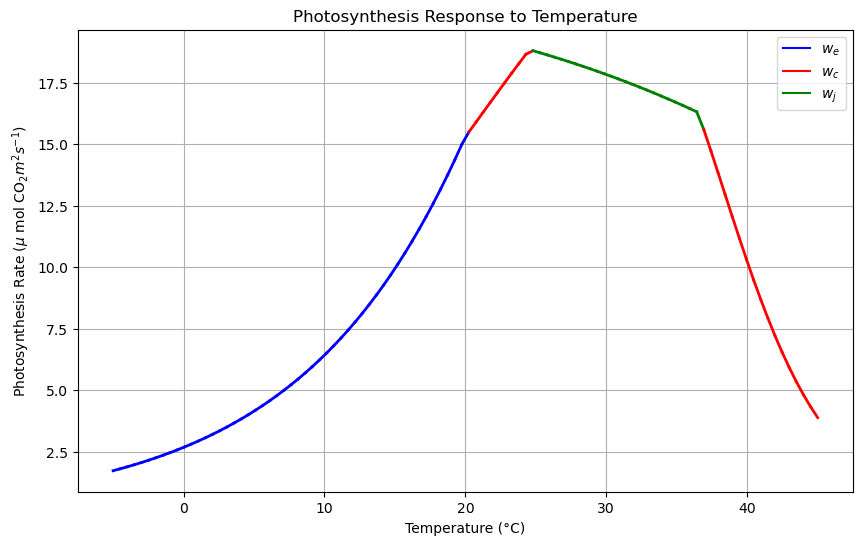

In [88]:
# 温度范围
co2_values = np.linspace(-5, 45, 100)

# 模拟光合作用响应，可以根据需要调整其他参数
photosynthesis_data = simulate_photosynthesis(co2_values, co2=400, other_params={'phi': 80, 'fDYL': 1, 'betat': 0.8})
# 可调节参数

visualize_photosynthesis_response(co2_values, photosynthesis_data)

### 3.3 光照强度影响

使用phi, 百分数

In [103]:
def simulate_photosynthesis_phi(phi_values, co2=400, other_params=None):
    if other_params is None:
        other_params = {}

    results = {'Aleaf': [], 'mode': []}

    for phi in phi_values:
        result = calculate_Aleaf(phi=phi, co2=co2, **other_params)
        results['Aleaf'].append(result[0])
        results['mode'].append(result[4])

    return results

In [104]:
def get_mode_color(mode):
    if mode == 'wc':
        return 'red'
    elif mode == 'we':
        return 'blue'
    elif mode == 'wj':
        return 'green'
    else:
        return 'black'

In [105]:
def visualize_photosynthesis_response_phi(phi_values, photosynthesis_data):
    plt.figure(figsize=(10, 6))

    for i in range(len(phi_values) - 1):
        phi1 = phi_values[i]
        phi2 = phi_values[i + 1]
        mode1 = photosynthesis_data['mode'][i]
        # mode2 = photosynthesis_data['mode'][i + 1]
        Aleaf1 = photosynthesis_data['Aleaf'][i]
        Aleaf2 = photosynthesis_data['Aleaf'][i + 1]

        plt.plot([phi1, phi2], [Aleaf1, Aleaf2], 
                 marker='o', 
                 markersize = 0,
                 linewidth = 2,
                 color=get_mode_color(mode1))

    plt.xlabel('$\phi$ , percent')
    plt.ylabel('Photosynthesis Rate ($\mu$ mol CO$_2 m^2 s^{-1}$)')
    plt.title('Effect of $\Phi$ on Photosynthesis Rate')
    plt.grid(True)

    # Manually create legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', label='$w_e$'),
        plt.Line2D([0], [0], color='red', label='$w_c$'),
        plt.Line2D([0], [0], color='green', label='$w_j$'),
    ]

    plt.legend(handles=legend_elements)

    plt.show()
    # we blue; wc red; wj green

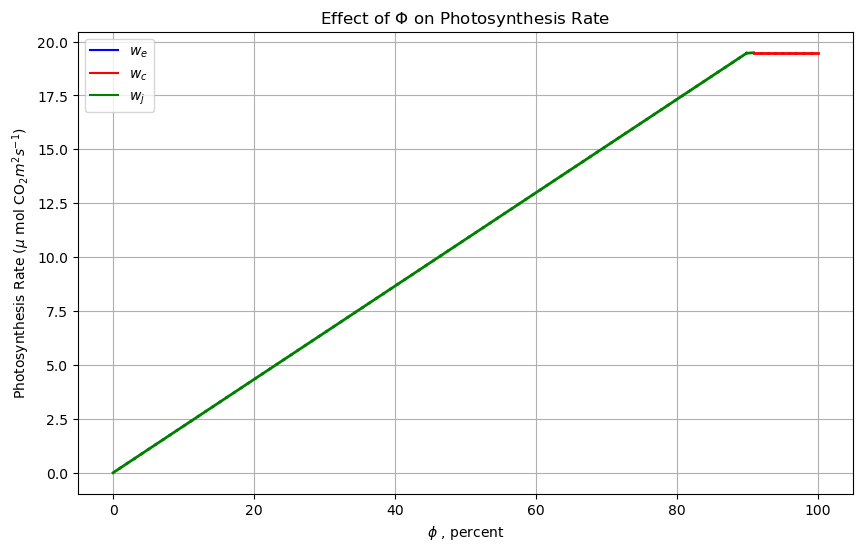

In [108]:
# phi 范围
co2_values = np.linspace(0, 100, 100)
# 模拟光合作用响应，可以根据需要调整其他参数
photosynthesis_data = simulate_photosynthesis_phi(
                                            co2_values, co2=350, other_params={
                                                                                # 'phi': 80, 
                                                                                'fDYL': 1, 'betat': 0.8
                                                                                })
# 可调节参数
visualize_photosynthesis_response_phi(co2_values, photosynthesis_data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# 请确保 calculate_Aleaf 函数正确定义，并在这里导入

def visualize_sunlit_effect(phi_values, Aleaf_values, mode_values):
    # 添加背景经纬网
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    for i in range(len(phi_values)):
        color = 'blue'  # 默认颜色
        Aleaf, mode = calculate_Aleaf(phi_values[i])
        if mode == 'wc':
            color = 'green'
        elif mode == 'we':
            color = 'red'
        elif mode == 'wj':
            color = 'purple'
        plt.scatter(phi_values[i], Aleaf_values[i], color=color, marker='o', s=40, label=mode)

    # 图例设置
    legend_labels = [r'$w_c$', r'$w_e$', r'$w_j$']
    legend_handles = [plt.Line2D([0], [0], marker='o',
                                 color=color,
                                 markerfacecolor='w', markersize=10,
                                 markeredgewidth=2)
                      for color in ['green', 'red', 'purple']]

    plt.legend(legend_handles, legend_labels)
    plt.xlabel('Phi')
    plt.ylabel("Photosynthesis Rate ($\mu$ mol CO$_2 m^2 s^{-1}$)")
    plt.title('Effect of Phi on Photosynthesis Rate')
    plt.show()

# 示例数据生成
co2_values = np.linspace(0, 100, 100)
Aleaf_values = []
mode_values = []

for phi in co2_values:
    result, mode = calculate_Aleaf(phi)
    Aleaf_values.append(result)
    mode_values.append(mode)

# 可视化
visualize_sunlit_effect(co2_values, Aleaf_values, mode_values)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_photosynthesis(phi_values, temperature=25, co2=350, other_params=None):
    if other_params is None:
        other_params = {}

    results = []

    for phi in phi_values:
        # 在这里调用你的 calculate_Aleaf 函数，传递 phi 和其他参数
        result, _ = calculate_Aleaf(Tv=temperature, co2=co2, phi=phi, 
                                    # **other_params
                                    )
        results.append(result)

    return results

def visualize_photosynthesis_response(phi_values, photosynthesis_rates):
    plt.plot(phi_values, photosynthesis_rates, marker='o', linestyle='-')
    plt.xlabel('Phi')
    plt.ylabel('Photosynthesis Rate ($\mu$ mol CO$_2 m^2 s^{-1}$)')
    plt.title('Photosynthesis Response to Phi')
    plt.grid(True)
    plt.show()

# phi 范围
co2_values = np.linspace(0, 100, 50)

# 模拟光合作用响应，可以根据需要调整其他参数
photosynthesis_rates = simulate_photosynthesis(co2_values, temperature=25, co2=400, other_params={'betat': 0.8})

# 可视化
visualize_photosynthesis_response(co2_values, photosynthesis_rates)
      


### 3.4 CO<sub>2</sub> 浓度影响

In [120]:

def simulate_photosynthesis_co2(co2_values, other_params=None):
    if other_params is None:
        other_params = {}

    results = {'Aleaf': [], 'mode': []}

    for co2 in co2_values:
        result = calculate_Aleaf(
                                #   phi=phi,
                                  co2=co2, **other_params,
                                  )
        results['Aleaf'].append(result[0])
        results['mode'].append(result[4])

    return results

In [121]:
def get_mode_color(mode):
    if mode == 'wc':
        return 'red'
    elif mode == 'we':
        return 'blue'
    elif mode == 'wj':
        return 'green'
    else:
        return 'black'

In [122]:
def visualize_photosynthesis_response_co2(co2_values, photosynthesis_data):
    plt.figure(figsize=(10, 6))

    for i in range(len(co2_values) - 1):
        co2_1 = co2_values[i]
        co2_2 = co2_values[i + 1]
        mode1 = photosynthesis_data['mode'][i]
        # mode2 = photosynthesis_data['mode'][i + 1]
        Aleaf1 = photosynthesis_data['Aleaf'][i]
        Aleaf2 = photosynthesis_data['Aleaf'][i + 1]

        plt.plot([co2_1, co2_2], [Aleaf1, Aleaf2], 
                 marker='o', 
                 markersize = 0,
                 linewidth = 2,
                 color=get_mode_color(mode1))

    plt.xlabel('$\phi$ , percent')
    plt.ylabel('Photosynthesis Rate ($\mu$ mol CO$_2 m^2 s^{-1}$)')
    plt.title('Effect of $\Phi$ on Photosynthesis Rate')
    plt.grid(True)

    # Manually create legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', label='$w_e$'),
        plt.Line2D([0], [0], color='red', label='$w_c$'),
        plt.Line2D([0], [0], color='green', label='$w_j$'),
    ]

    plt.legend(handles=legend_elements)

    plt.show()
    # we blue; wc red; wj green


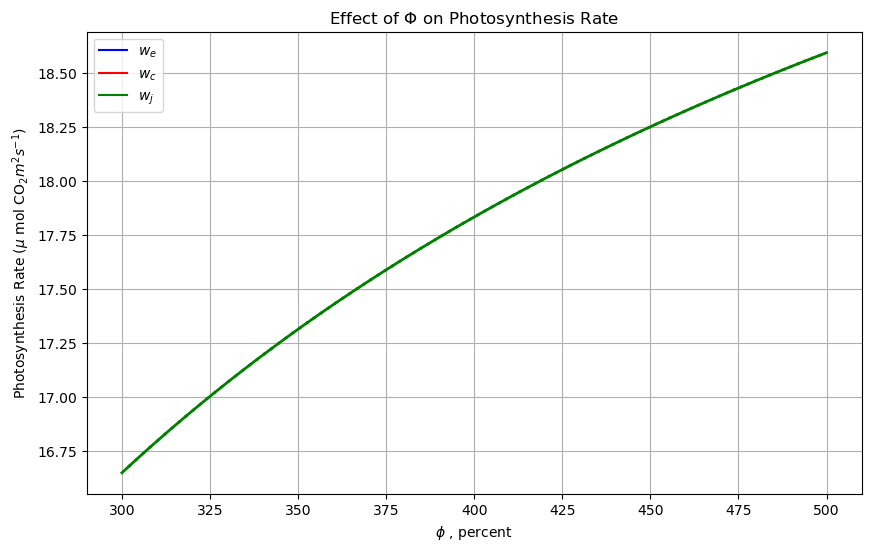

In [125]:
# phi 范围
co2_values = np.linspace(300, 500, 100)
# 模拟光合作用响应，可以根据需要调整其他参数
photosynthesis_data = simulate_photosynthesis_co2(
                                            co2_values, 
                                            # co2=350, 
                                            other_params={
                                                                                'phi': 80, 
                                                                                'fDYL': 1, 'betat': 0.8
                                                                                })
# 可调节参数
visualize_photosynthesis_response_co2(co2_values, photosynthesis_data)

## 4. 结果与分析

### 4.1 温度影响

### 4.2 光照强度影响

### 4.3 CO<sub>2</sub> 浓度影响

由Fig.3 所示, 二氧化碳的浓度变化仅作用于wc和wj, 不作用于we, 前者参数包含ci, 即二氧化碳分压, 后者只受Vcmax的影响. 